<a href="https://colab.research.google.com/github/teraz1112/who-is-Author/blob/main/manga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import os

train_losses = []
val_losses = []
train_acc = []
val_acc = []

# 画像を白黒化するための変換を定義
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),  # 白黒化
        transforms.Resize(224),  # 画像のリサイズ
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # 正規化
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(),  # 白黒化
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

# データセットを読み込む際に、白黒化変換を適用
data_dir = '/content/drive/MyDrive/研修Ⅰ/Datasets/漫画'  # データセットのディレクトリを指定
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# モデルの定義と最終層の変更
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1チャンネルの入力に対応するように畳み込み層を変更
model_ft.fc = torch.nn.Linear(num_ftrs, 7)  # 出力を7つのクラスに変更

model_ft = model_ft.to(device)

# 損失関数、オプティマイザ、スケジューラの設定
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# トレーニング関数の定義
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            train_losses.append(epoch_loss)
            val_losses.append(epoch_loss)
            train_acc.append(epoch_acc)
            val_acc.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

# モデルのトレーニング
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


Epoch 0/9
----------
train Loss: 1.5231 Acc: 0.4675
val Loss: 1.1697 Acc: 0.5994

Epoch 1/9
----------
train Loss: 0.8813 Acc: 0.6981
val Loss: 0.9819 Acc: 0.6303

Epoch 2/9
----------
train Loss: 0.6385 Acc: 0.7936
val Loss: 1.8320 Acc: 0.6106

Epoch 3/9
----------
train Loss: 0.5208 Acc: 0.8255
val Loss: 0.9897 Acc: 0.7171

Epoch 4/9
----------
train Loss: 0.3561 Acc: 0.8790
val Loss: 0.9591 Acc: 0.7115

Epoch 5/9
----------
train Loss: 0.4775 Acc: 0.8573
val Loss: 1.0835 Acc: 0.7367

Epoch 6/9
----------
train Loss: 0.2940 Acc: 0.9006
val Loss: 0.6713 Acc: 0.7815

Epoch 7/9
----------
train Loss: 0.1514 Acc: 0.9605
val Loss: 0.6443 Acc: 0.7955

Epoch 8/9
----------
train Loss: 0.1524 Acc: 0.9541
val Loss: 0.6564 Acc: 0.8011

Epoch 9/9
----------
train Loss: 0.1833 Acc: 0.9427
val Loss: 0.7041 Acc: 0.7703

Training complete in 8m 0s
Best val Acc: 0.8011


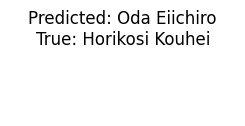

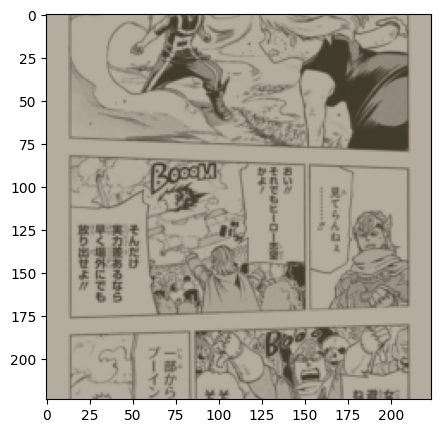

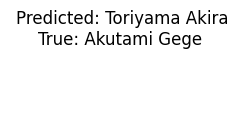

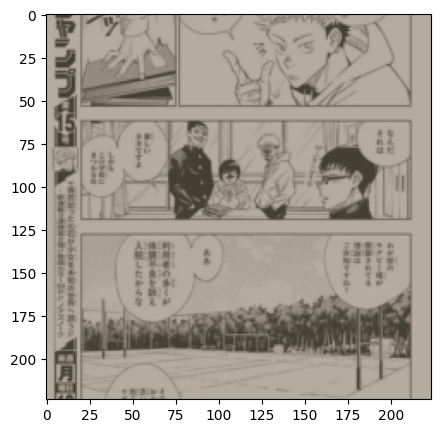

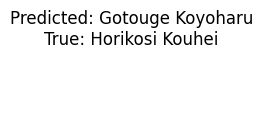

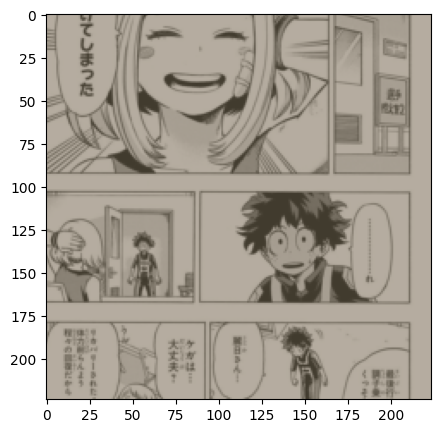

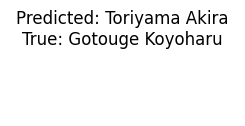

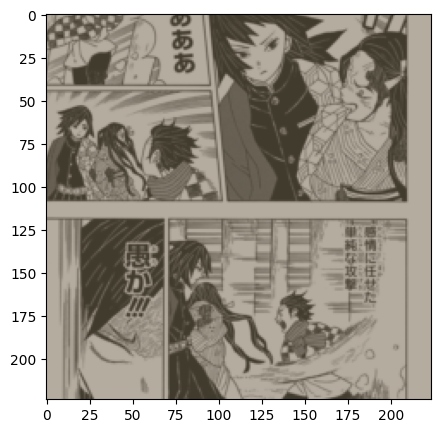

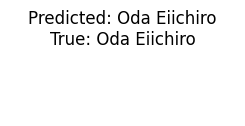

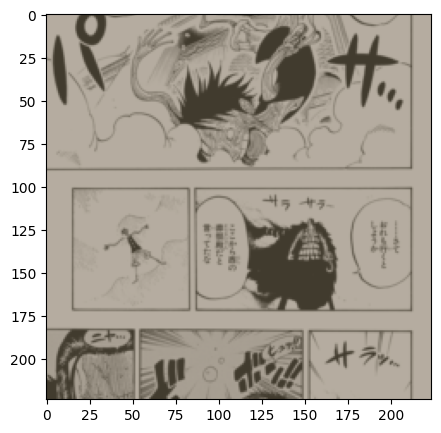

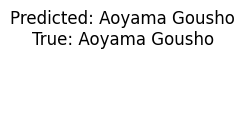

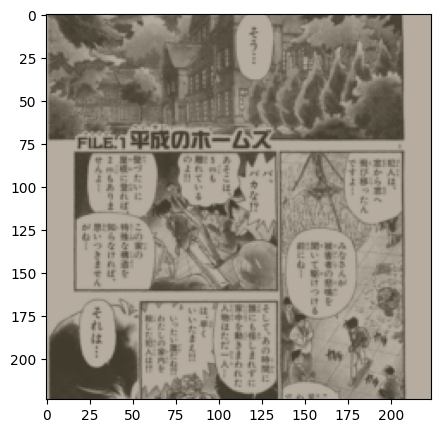

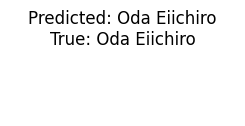

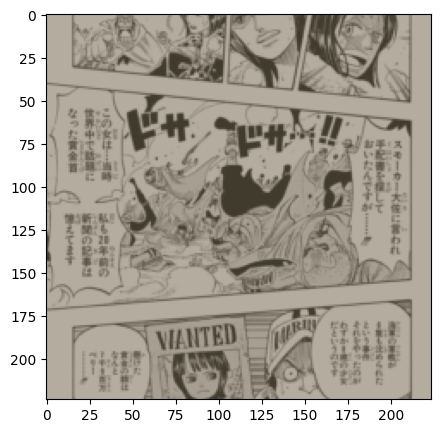

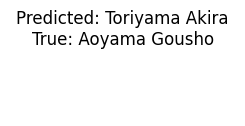

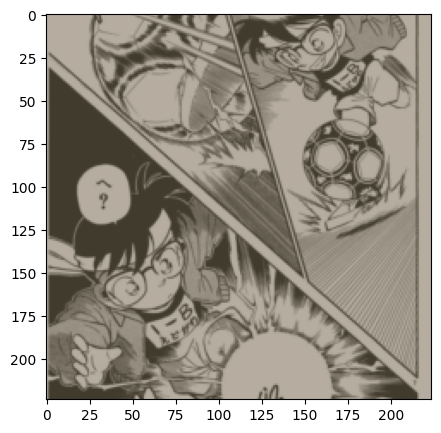

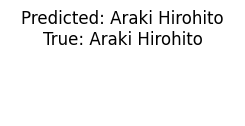

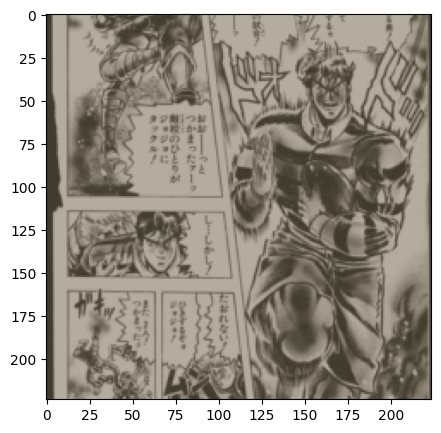

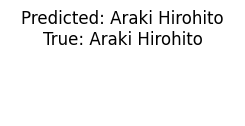

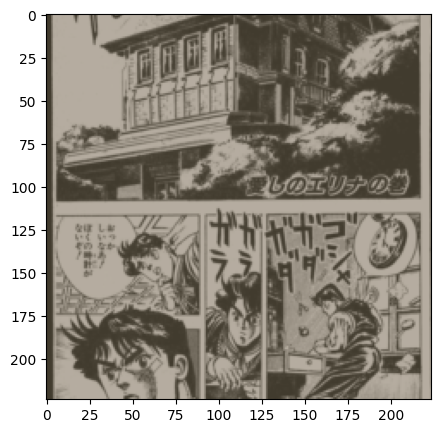

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow_large(inp, title=None, figsize=(5, 5)):
    """Imshow for Tensor with larger display size."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # Create a larger figure
    plt.figure(figsize=figsize)

    # Display the image
    plt.imshow(inp)

    if title is not None:
        plt.title(title)

    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                predicted_class = preds[j].item()
                predicted_author = class_names[predicted_class]  # 推測されたクラスに対応する作者名を取得
                true_class = labels[j].item()
                true_author = class_names[true_class]  # 正解のクラスに対応する作者名を取得
                ax.set_title(f'Predicted: {predicted_author}\nTrue: {true_author}')
                imshow_large(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# visualize_model関数を呼び出して結果を表示
visualize_model(model_ft)